# Sepsis DAG - INR

In [90]:
import os
import sys
import copy
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import pickle

In [91]:
from utils.misc import readPickle, sampleGaussian
sys.path.append("/Users/sriharimohan/Machine Learning/Sontag3/dmm/dmm/model_th")
import evaluate
import dmm
from evaluate import reconstruct
from evaluate import infer
from dmm import DMM

## Data Generation Functions

In [92]:
class Context:
    def __init__(self, ndim, u):
        self.ndim = ndim
        self.u = u
        self.contextWeights = np.ones(ndim)
    def set_contextWeights(self, weights):
        self.contextWeights = weights
    def degrade_u(self):
        self.u = np.multiply(self.contextWeights, self.u)

In [93]:
def transition(a, u):
    return np.dot(u,a)

# exponential decay on likelihood of intervention
def indicate_administration(y_t, tdiff):
    decay = (np.e ** (-DECAY * tdiff))
    p = (1-decay) * scipy.stats.norm(Y_MEAN, Y_SIGMA).cdf(y_t)
    flag = random.random() < p
    return flag

def administer(a, context):
    u_t = context.u * (1-CONTROL_DECAY)
    y_t = np.dot(u_t,a)
    return y_t, u_t

In [94]:
def run_simulation(time_length, a, context):
    U = np.zeros((time_length, context.ndim))
    y = np.zeros(time_length)
    U[0,:], y[0] = context.u, transition(a, context.u)
    adminstered = []
    tlast = 0
    for t in range(1, time_length):
        context.degrade_u()
        y_t = transition(a, context.u)
        if indicate_administration(y_t, t-tlast):
            y_t, context.u = administer(a, context)
            adminstered.append(t)
            tlast = t
        U[t,:] = context.u
        y[t] = y_t
    return U, y, adminstered

In [95]:
def plot_trajectory(y, administered):
    times = list(range(len(y)))
    fig = plt.figure()
    plt.plot(times, y, '-ro')
    plt.xlabel('time (hr)')
    plt.ylabel('INR')
    plt.title('observed INR trajectory and interventions')
    for t in administered:
        plt.axvline(x=t, color='g', linestyle='--')
    fig.set_figheight(8)
    fig.set_figwidth(15)
    green_patch = mpatches.Patch(color='green', label='Adminstration of treatment')
    plt.legend(handles=[green_patch])
    plt.show()

#### Load trajectories for multiple patients

In [96]:
def load_trajectories(num_ts, time_length, a, context):
    X = np.zeros((num_ts,time_length,context.ndim))
    Y = np.zeros((num_ts,time_length,1))
    for i in range(num_ts):
        cxt = copy.deepcopy(context)
        U, y, administered = run_simulation(time_length,a,cxt)
        y = y.reshape(len(y),1) # could binarize if desired
        X[i,:,:] = U
        Y[i,:,:] = y
    plot_trajectory(y, administered)
    return X, Y

#### Convert simulated dataset to format in clinicalml/structuredinf (for integration with DMM learning)

In [97]:
def write_to_file(file, x):
    file = open(file,'wb')
    pickle.dump(x,file)
    file.close()

In [98]:
def load_Dataset(num_ts, time_length):
    global Y_MEAN
    global Y_SIGMA
    global SIGMA
    global DECAY
    global NDIM
    global initial_u
    global CONTROL_DECAY
    # Context initialization
    Y_MEAN, Y_SIGMA = 3.5, 0.5
    SIGMA = 0.02
    DECAY = 0.033
    NDIM = 6
    CONTROL_DECAY = 0.5
    # clotting factors concentrate: Factor VIII
    # anticoagulant: warfarin
    # vitamin K amounts in mcg
    # indicator on particular chronic condition
    # platelet transfusion in ml/kg
    initial_u = np.array([20, 10, 42, 120, 2, 10])
    context = Context(NDIM, initial_u)
    contextWeights = np.array([1.135, 1.04, 1, 1.07, 1, 1.06])
    context.set_contextWeights(contextWeights)
    a = np.array([0.03,0.02,0.02,0.01,0.02,0.03])
    X, Y = load_trajectories(num_ts, time_length, a, context)
    print('training on control inputs of shape: ' + str(X.shape))
    print('training on observation sequence of shape: ' + str(Y.shape))
    Ntrain = int(0.6*Y.shape[0])
    Nvalid = int(0.2*Y.shape[0])
    T , dim_observations  = Y.shape[1],Y.shape[2]
    shufidx = np.random.permutation(num_ts)
    indices = {}
    indices['train'] = shufidx[:Ntrain]
    indices['valid'] = shufidx[Ntrain:Ntrain+Nvalid]
    indices['test']  = shufidx[Ntrain+Nvalid:]
    dataset = {}
    for k in ['train','valid','test']:
        dataset[k]   = {}
        dataset[k]['tensor']   = Y[indices[k]]  
        dataset[k]['mask']     = np.ones_like(dataset[k]['tensor'][:,:,0])
        dataset[k]['control']  = X[indices[k]]
    dataset['dim_observations'] = dim_observations
    dataset['dim_controls'] = NDIM
    dataset['data_type'] = 'real'
    return dataset

#### Simulated sample trajectory in INR (simplified here for debugging)

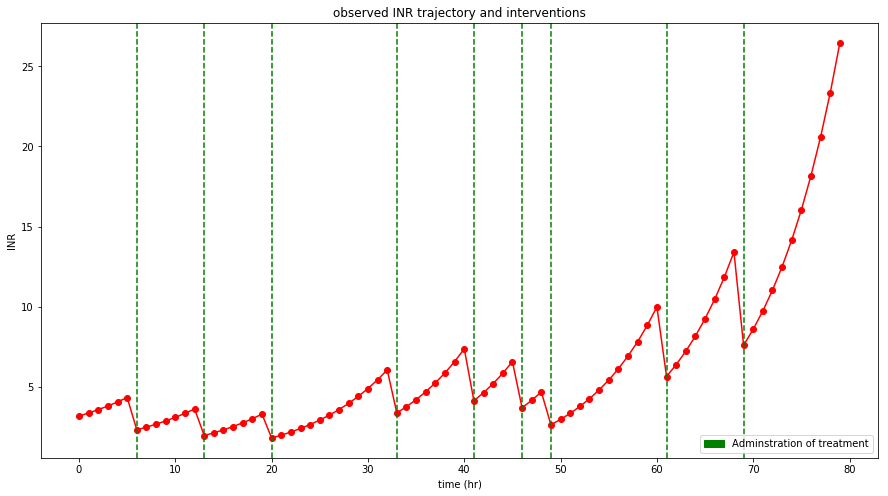

training on control inputs of shape: (50, 80, 6)
training on observation sequence of shape: (50, 80, 1)


In [100]:
dataset = load_Dataset(50,80)

## Evaluate Deep Markov Model

In [71]:
def evaluated(dataset, 
              params_path,
              pfile_path,
              reload_path,
              ids):
    dmm = loadDMM(params_path, pfile_path, reload_path)
    params = reconstruct(dmm, dataset['test'])
    pred = params[0]
    for idx in ids:
        compare_trajectories(dataset['test'], pred[idx,:,:], idx)
        
def loadDMM(params_path, pfile_path, reload_path):
    params = readPickle(params_path)[0]
    pfile = readPickle(pfile_path)[0]
    reloadFile = readPickle(reload_path)[0]
    dmm = DMM(params, paramFile=pfile, reloadFile=reloadFile)
    return dmm

def compare_trajectories(dataset, pred, idx, forward=False, time=0):
    real = dataset['tensor'][idx,:,:].flatten()
    pred = pred.flatten()
    assert (real.shape == pred.shape), 'real and pred should have same shape, real has shape {}, pred has shape {}'.format(real.shape, pred.shape)
    plt.close('all')
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])
    ax2.set_xlabel('time (hr)')
    ax1.set_ylabel('INR')
    ax2.set_ylabel('INR')
    ax1.set_title('observed vs. predicted INR trajectories (seq: ' + str(idx) + ')')
    times = np.array(range(len(real)))
    ax1.plot(times, real, '-ro')
    ax2.plot(times, pred, '-bo')
    gs1.tight_layout(fig)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    if forward:
        ax1.axvline(x=time, c='black')
        ax2.axvline(x=time, c='black')
    plt.show()

#### Reconstruct the input

In [104]:
directory = "../dmm/dmm/expt_template/"
dataset = readPickle(directory + "inr.pkl")[0]
sequence_ids = list(range(dataset['test']['tensor'].shape[0]))

Read  1  objects


Read  1  objects
Read  1  objects
Read  1  objects
	<<Reloading Model>>
	<<Loading structure (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-config.pkl) and model (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-EP170-params.npz) / opt (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-EP170-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 6049005>>
	<<Anneal = 1 in 2000.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 20.0631 seconds>>


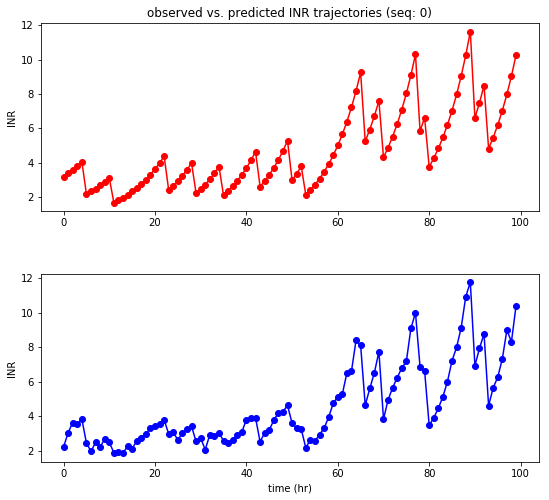

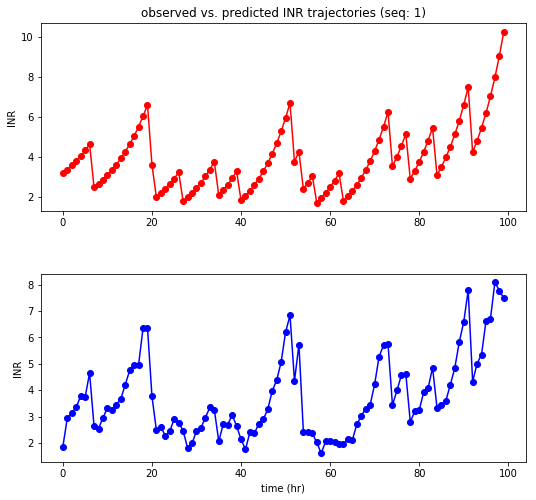

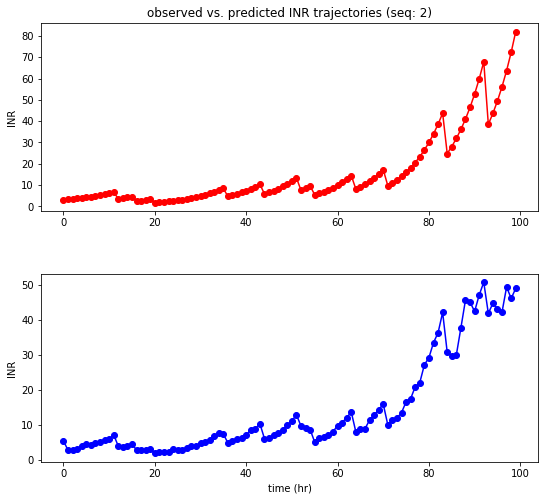

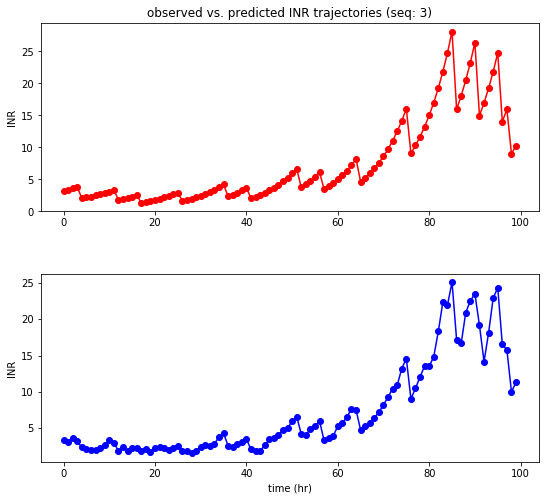

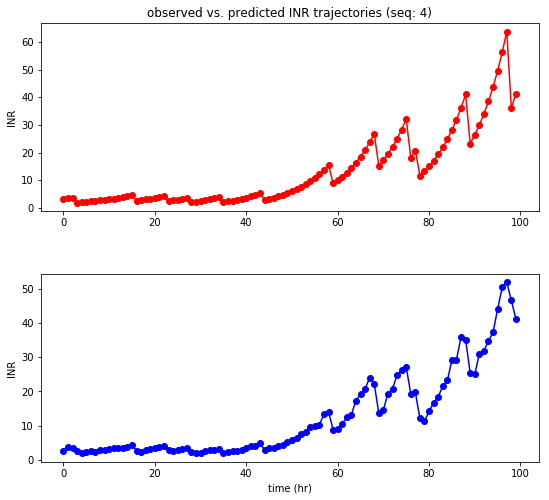

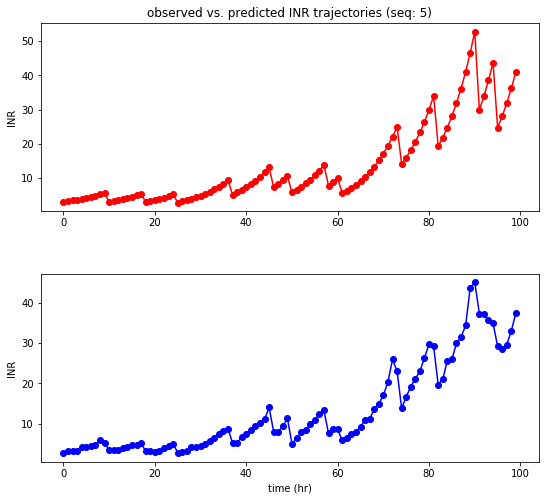

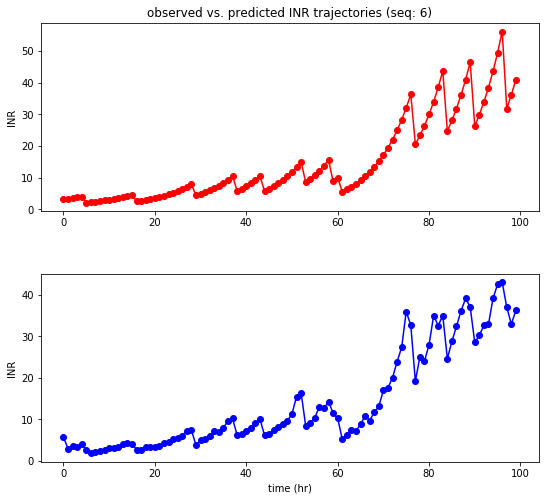

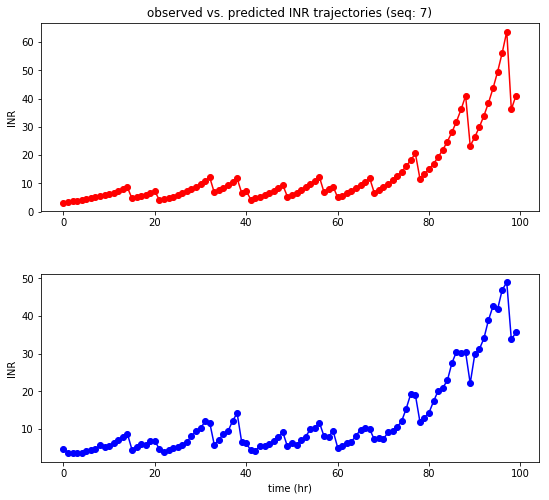

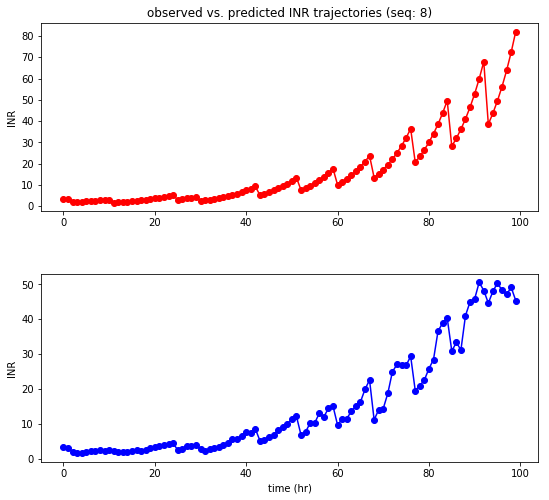

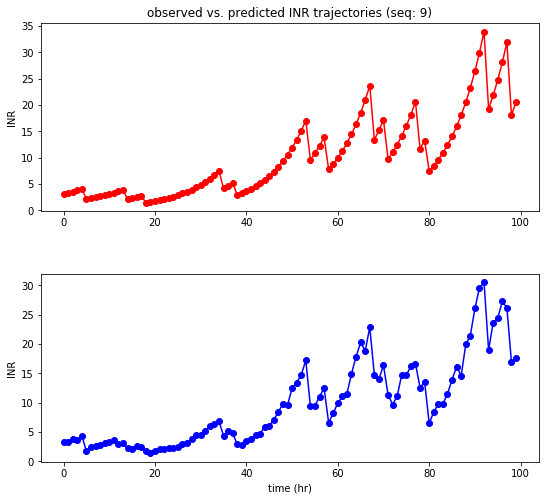

In [105]:
params_path = directory + "model_params.pkl"
pfile_path = directory + "model_pfile.pkl"
reload_path = directory + "model_reload.pkl"
evaluated(dataset, params_path, pfile_path, reload_path, sequence_ids)

#### Counterfactual forecasting

In [106]:
t=60
dmm = loadDMM(params_path, pfile_path, reload_path)
dataset = readPickle(directory + "inr.pkl")[0]
test_length = dataset['test']['tensor'].shape[1]
dataset['test']['tensor'] = dataset['test']['tensor'][:,0:t,:]

Read  1  objects
Read  1  objects
Read  1  objects
	<<Reloading Model>>
	<<Loading structure (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-config.pkl) and model (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-EP170-params.npz) / opt (./chkpt-inr/DMM_lr-0_0008-dh-100-ds-100-nl-relu-bs-20-ep-200-rs-600-rd-0_1-infm-LR-tl-2-el-2-ar-2000_0-use_p-approx-rc-lstm-DKF-EP170-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 6049005>>
	<<Anneal = 1 in 2000.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 20.2636 seconds>>
Read  1  objects


In [107]:
z_s = infer(dmm, dataset['test'])
z = z_s[0][:, t-1, :].reshape(z_s[0].shape[0], 1, z_s[0].shape[2])
all_zs  = [np.copy(z)]
for i in range(test_length-t):
    u = dataset['test']['controls'][:,t+i,:].reshape(dataset['test']['controls'].shape[0],
                                                    1,
                                                    dataset['test']['controls'].shape[2])
    mu, cov = dmm._transition(z=z,U=u)
    mu, cov = mu.eval(), cov.eval()
    z = sampleGaussian(mu,np.log(cov))
    all_zs.append(np.copy(z))

In [108]:
zvec = np.concatenate(all_zs,axis=1)
params = dmm.emission_fxn(zvec)
pred = params[0]
x_pred = np.concatenate((dataset['test']['tensor'][:, 0:t-1, :], pred), axis = 1)

Read  1  objects


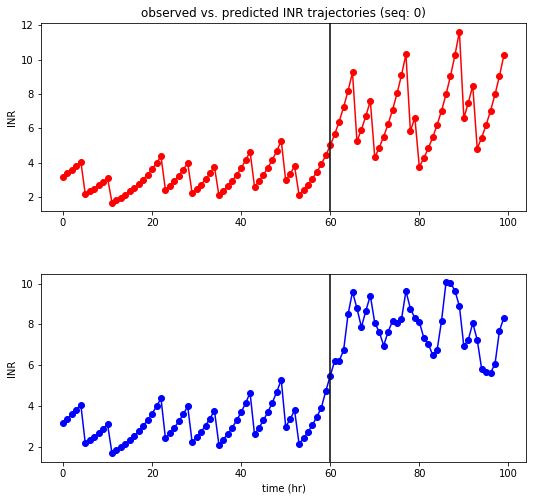

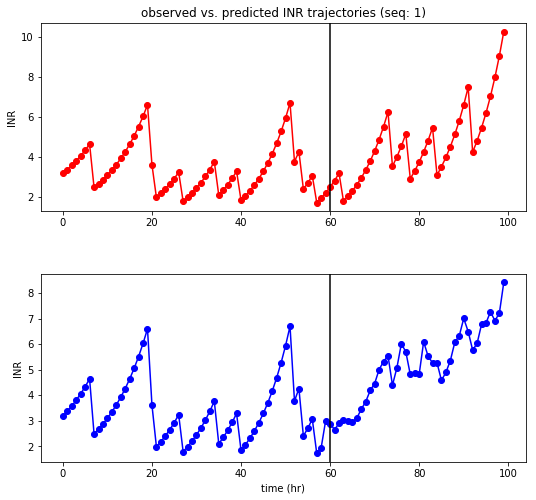

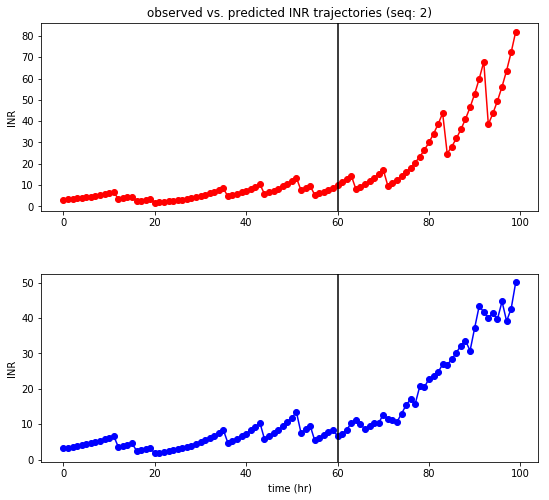

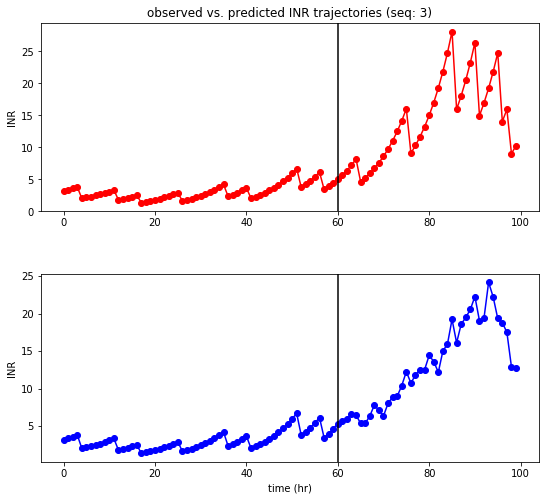

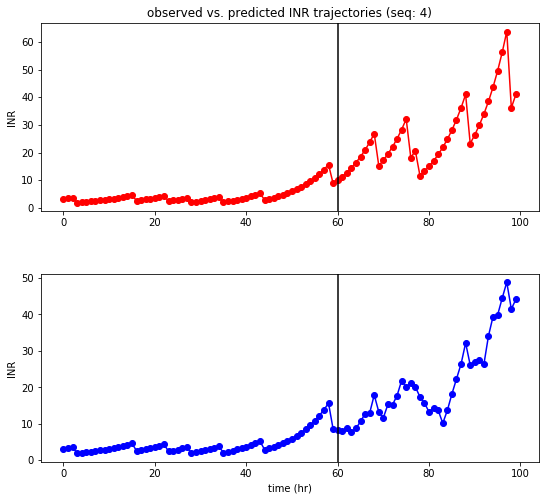

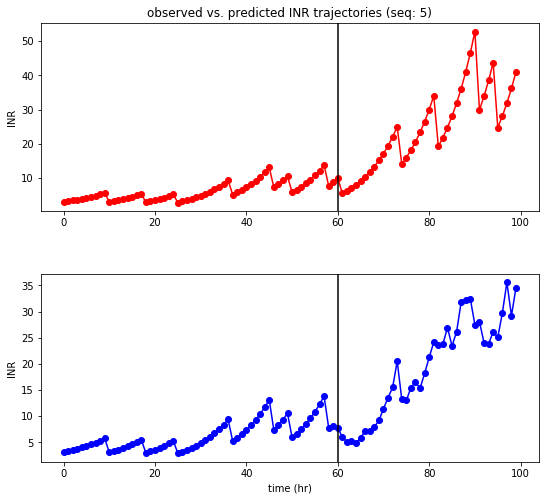

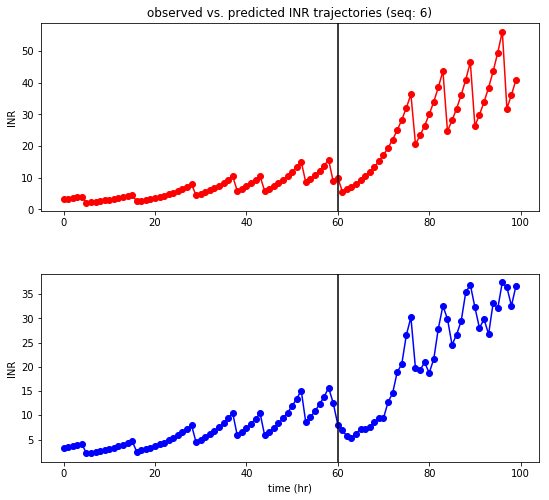

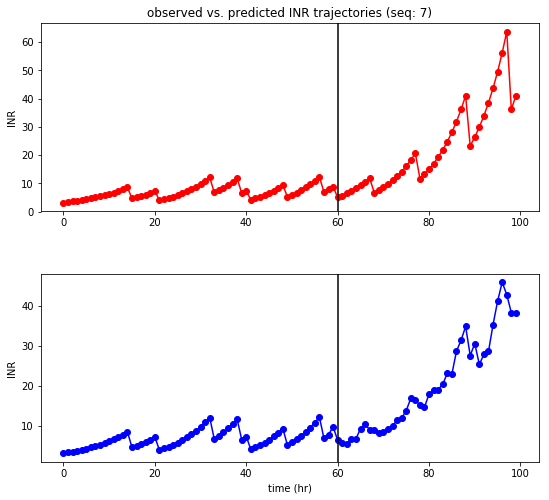

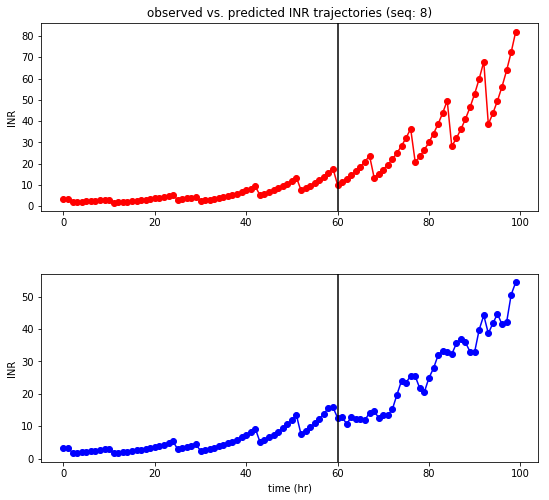

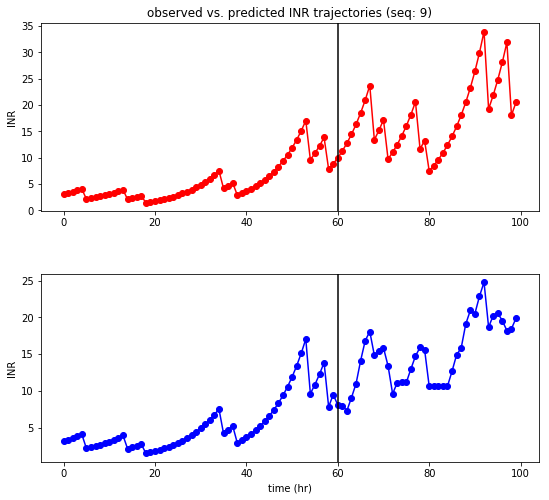

In [109]:
dataset = readPickle(directory + "inr.pkl")[0]
for idx in range(x_pred.shape[0]):
    compare_trajectories(dataset['test'], x_pred[idx,:,:], idx, forward = True, time = t)